In [13]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [14]:
IMAGE_SIZE = (224, 224, 3)
BATCH_SIZE = 8
EPOCHS = 25
LEARNING_RATE = 0.0001

In [15]:
# Load image
DATASET_CLEAN_PATH = os.path.join("Dataset", "Dataset Clean")

image_list = []
class_list = []
class_names = {}

for idx, label in enumerate(os.listdir(DATASET_CLEAN_PATH)):
    for filename in os.listdir(os.path.join(DATASET_CLEAN_PATH, label)):
        image_path = os.path.join(DATASET_CLEAN_PATH, label, filename)
        image = load_img(image_path, color_mode="rgb", target_size=IMAGE_SIZE[:2])
        image = np.asarray(image) / 255.
        image_list.append(image)
        class_list.append(idx)

    class_names[idx] = label
    print(f"Class {label} loaded successfully")

Class batik-betawi loaded successfully
Class batik-parang loaded successfully
Class batik-megamendung loaded successfully


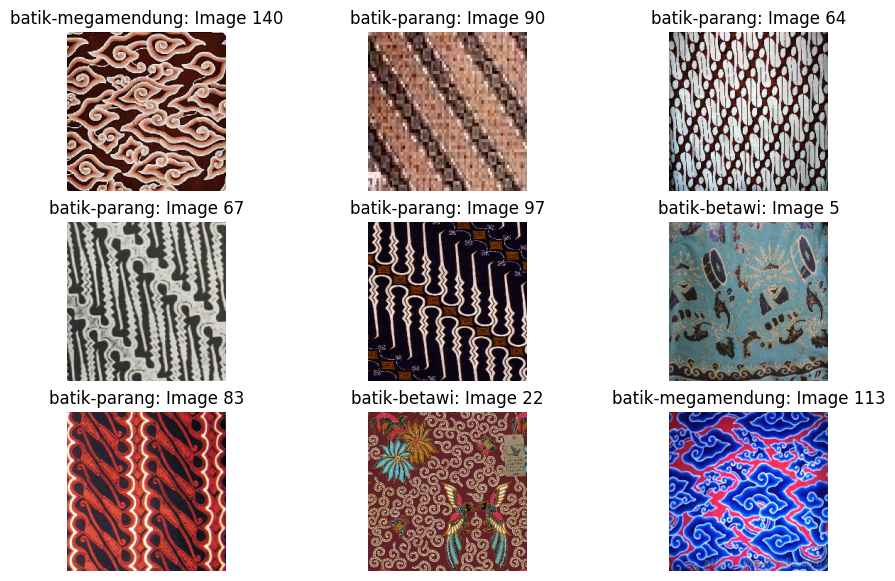

In [16]:
from matplotlib import pyplot as plt
import random

plt.figure(figsize=(11, 7))
for i in range(9):
    plt.subplot(3, 3, i+1)
    randomNum = random.randrange(0, len(image_list))
    plt.imshow(image_list[randomNum])
    plt.axis('off')
    plt.title(f"{class_names[class_list[randomNum]]}: Image {randomNum}")

plt.show()

In [17]:
from tensorflow.keras.utils import to_categorical

image_list = np.array(image_list)
class_list = np.array(class_list)
class_list = to_categorical(class_list, num_classes=len(class_names))

In [18]:
from sklearn.model_selection import train_test_split

# Train Test Split
X_train, X_temp, y_train, y_temp = train_test_split(image_list, class_list, test_size=0.2, random_state=42, shuffle=True, stratify=class_list)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True, stratify=y_temp)

print(f"Length of training data {len(y_train)}")
print(f"Length of testing data {len(y_test)}")
print(f"Length of validation data {len(y_val)}")

Length of training data 116
Length of testing data 15
Length of validation data 14


In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential

base_model = MobileNetV2(include_top=False, input_shape=IMAGE_SIZE, weights='imagenet')

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
)

datagen.fit(X_train)
train_ds = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [21]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 64)                81984     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2340163 (8.93 MB)
Trainable params: 2306

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[early_stopping],
    steps_per_epoch=len(X_train) // BATCH_SIZE
)

Epoch 1/25
14/14 [==============================] - 8s 190ms/step - loss: 1.1859 - accuracy: 0.4815 - val_loss: 0.6176 - val_accuracy: 0.7857
Epoch 2/25
14/14 [==============================] - 2s 159ms/step - loss: 0.5425 - accuracy: 0.7685 - val_loss: 0.4613 - val_accuracy: 0.8571
Epoch 3/25
14/14 [==============================] - 2s 152ms/step - loss: 0.3636 - accuracy: 0.8981 - val_loss: 0.3836 - val_accuracy: 0.7857
Epoch 4/25
14/14 [==============================] - 2s 157ms/step - loss: 0.2914 - accuracy: 0.8889 - val_loss: 0.3086 - val_accuracy: 0.7857
Epoch 5/25
14/14 [==============================] - 2s 164ms/step - loss: 0.2892 - accuracy: 0.9018 - val_loss: 0.2764 - val_accuracy: 0.8571
Epoch 6/25
14/14 [==============================] - 2s 157ms/step - loss: 0.2204 - accuracy: 0.9074 - val_loss: 0.2648 - val_accuracy: 0.9286
Epoch 7/25
14/14 [==============================] - 2s 160ms/step - loss: 0.1444 - accuracy: 0.9630 - val_loss: 0.2623 - val_accuracy: 0.9286
Epoch 

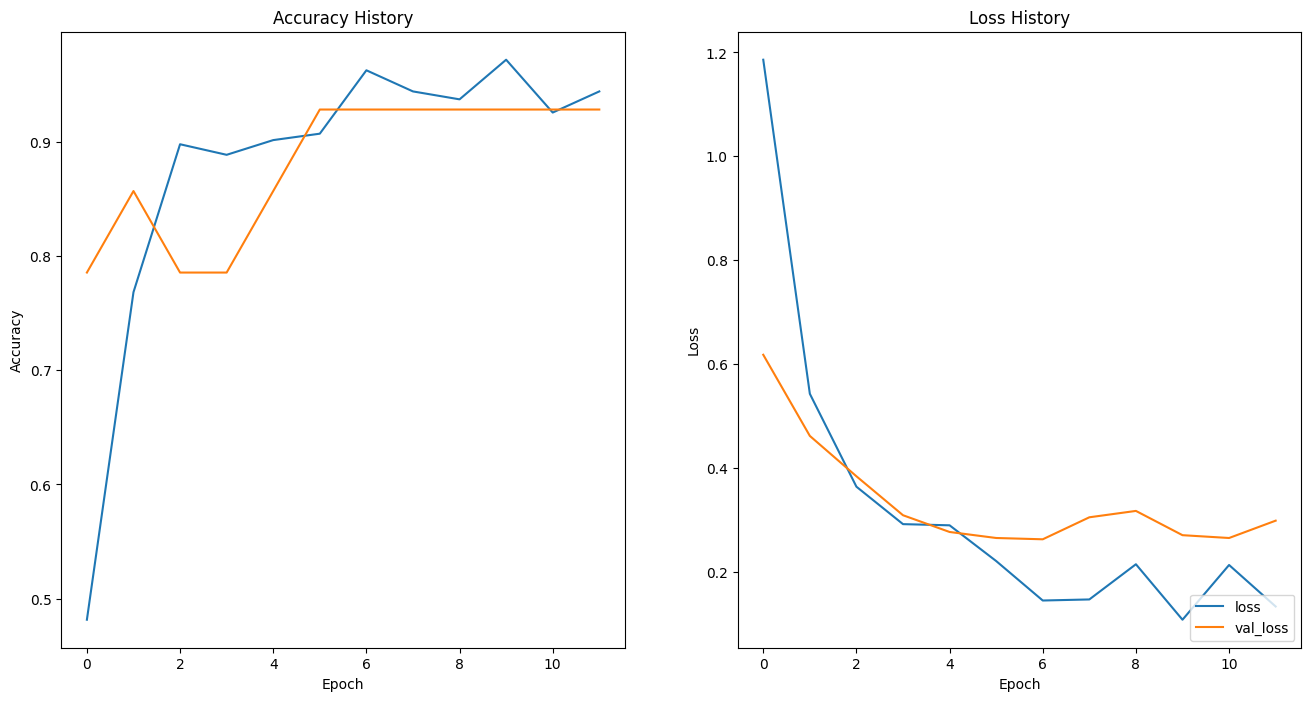

In [23]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy History")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss History")

plt.legend(loc='lower right')
plt.show()

In [24]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

1/1 [==============================] - 0s 84ms/step - loss: 0.3886 - accuracy: 0.8000
Loss: 0.38864028453826904
Accuracy: 0.800000011920929


1/1 [==============================] - 0s 25ms/step


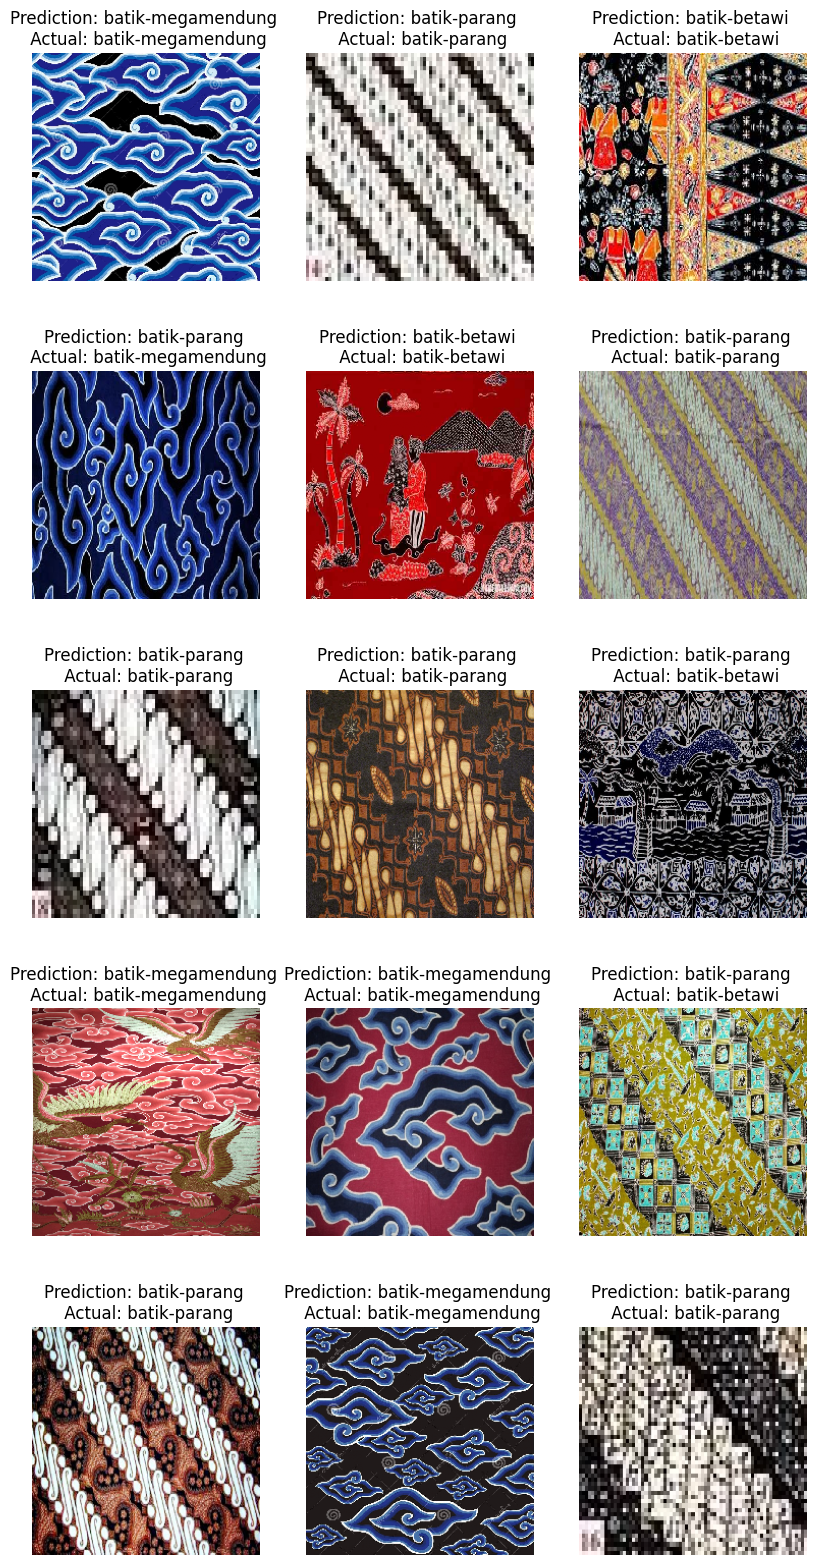

In [26]:
import random

plt.figure(figsize=(10, 20))
for i in range(15):
    plt.subplot(5, 3, i+1)
    prediction = model.predict(X_test[i].reshape(1, 224, 224, 3))
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f"Prediction: {class_names[np.argmax(prediction)]} \n Actual: {class_names[np.argmax(y_test[i])]}")

In [27]:
model.save("models/MobileNet-finetuned.h5")

/opt/anaconda3/envs/AI/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
